## Simple Regression Tree with Time Series Data

Regression trees make predictions based on the mean outcome value for the training samples assigned to a given node and typically rely on the mean-squared error to select optimal rules during recursive binary splitting.

Given a training set, the algorithm iterates over the predictors, $X_1, X_2, ..., X_p$, and possible cutpoints, $s_1, s_2, ..., s_N$, to find an optimal combination. The optimal rule splits the feature space into two regions, $\{X\mid X_i &lt; s_j\}$ and $\{X\mid X_i &gt; s_j\}$, with values for the $X_i$ feature either below or above the $s_j$ threshold so that predictions based on the training subsets maximize the reduction of the squared residuals relative to the current node.

In [1]:
import warnings
warnings.filterwarnings('ignore')


%matplotlib inline

import os, sys
from pathlib import Path

import numpy as np
from scipy.stats import spearmanr
import pandas as pd

import matplotlib.pyplot as plt
from matplotlib.ticker import FuncFormatter
from matplotlib import cm
import seaborn as sns


from sklearn.tree import DecisionTreeClassifier, DecisionTreeRegressor, export_graphviz, _tree
from sklearn.linear_model import LinearRegression, LogisticRegression
from sklearn.model_selection import train_test_split, GridSearchCV, learning_curve
from sklearn.metrics import roc_auc_score, roc_curve, mean_squared_error, make_scorer
import graphviz

from joblib import parallel_backend

import xgboost as xgb

import statsmodels.api as sm

In [2]:
sys.path.insert(1, os.path.join(sys.path[0], '..'))
from utils import MultipleTimeSeriesCV

In [3]:
results_path = Path('results', 'decision_trees')
if not results_path.exists():
    results_path.mkdir(parents=True)

## Data Load

In [10]:
file_name = r'..\..\data\Experiments\ES_NQ\Feature_Engineering_2020_2021_ES_NQ.parquet'
data = pd.read_parquet(file_name).reset_index().drop(columns = ['Date','Time'])

In [5]:
X2 = data.loc[:, ['target', 'return_1m']]
X2.columns = ['y', 't-1']
X2['t-2'] = data.groupby('ticker').return_1m.shift()
X2 = X2.dropna()
X2.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1021863 entries, 1 to 1021864
Data columns (total 3 columns):
 #   Column  Non-Null Count    Dtype  
---  ------  --------------    -----  
 0   y       1021863 non-null  float64
 1   t-1     1021863 non-null  float64
 2   t-2     1021863 non-null  float64
dtypes: float64(3)
memory usage: 31.2 MB


In [6]:
y2 = X2.y
X2 = X2.drop('y', axis=1)

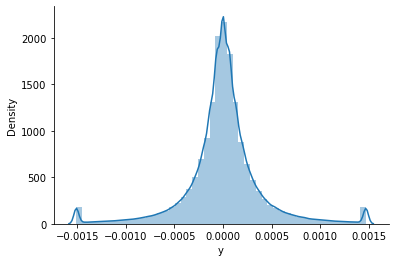

In [7]:

sns.distplot(y2)
sns.despine();

Let's start with a simplified example to facilitate visualization and only use two months of lagged returns to predict the following month, in the vein of an AR(2) model from the last chapter:

In [9]:
reg_tree_t2 = DecisionTreeRegressor(criterion='mse',
                                    splitter='best',
                                    max_depth=6,
                                    min_samples_split=2,
                                    min_samples_leaf=50,
                                    min_weight_fraction_leaf=0.0,
                                    max_features=None,
                                    random_state=42,
                                    max_leaf_nodes=None,
                                    min_impurity_decrease=0.0,
                                    min_impurity_split=None)

In [10]:
%%timeit
reg_tree_t2.fit(X=X2, y=y2)

1.85 s ± 56.5 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [11]:
reg_tree_t2.fit(X=X2, y=y2)

DecisionTreeRegressor(max_depth=6, min_samples_leaf=50, random_state=42)

In [ ]:
out_file = results_path / 'reg_tree_t2.dot'
dot_data = export_graphviz(reg_tree_t2,
                          out_file=out_file.as_posix(),
                          feature_names=X2.columns,
                          max_depth=2,
                          filled=True,
                          rounded=True,
                          special_characters=True)
if out_file is not None:
    dot_data = Path(out_file).read_text()



In [16]:
#graphviz.Source(dot_data)

In [ ]:
## Cross Validation Time Series ML

In [11]:
n_splits = 10
train_period_length = 60
test_period_length = 1
lookahead = 1

cv = MultipleTimeSeriesCV(n_splits=n_splits,
                          train_period_length=train_period_length,
                          test_period_length=test_period_length,
                          lookahead=lookahead)

In [12]:
data = data.rename(columns = {'timestamp':'date'}).set_index(['ticker','date'])

In [17]:
data['hour'] = data['hour'].astype(int)
data['minute'] = data['minute'].astype(int)

In [33]:
X = data.drop(columns= ['Open', 'High', 'Low','target'])
Y = data['target']

In [34]:
params = {'eta' : [0.01, 0.03, 0.05, 0.1, 0.15, 0.3], 
         'n_estimators' : [100, 200, 500, 1000]
         }
        
n_jobs = -1
verbose = 0

xgb_regressor = xgb.XGBRegressor()

grid_search = GridSearchCV(estimator = xgb_regressor, param_grid = params, cv = cv, scoring= 'neg_mean_squared_error', verbose = verbose)

with parallel_backend('threading', n_jobs = n_jobs):
    
    grid_search.fit(X, Y)

    results = grid_search.cv_results_

    print(results)

Fitting 10 folds for each of 24 candidates, totalling 240 fits
{'mean_fit_time': array([0.16680157, 0.30389953, 0.72418234, 1.39644167, 0.1552068 ,
       0.30980041, 0.69640009, 1.39482298, 0.15979984, 0.30489917,
       0.68992069, 1.36849978, 0.16030061, 0.30910258, 0.72599857,
       1.41074061, 0.18056643, 0.30899906, 0.67910147, 1.36990032,
       0.15789986, 0.31060333, 0.7166163 , 1.11912756]), 'std_fit_time': array([0.01182227, 0.01719484, 0.02814397, 0.06561156, 0.01170067,
       0.02630466, 0.02566315, 0.0622959 , 0.01170366, 0.01369212,
       0.02540649, 0.0544595 , 0.01536858, 0.01398897, 0.02462937,
       0.05409072, 0.03984742, 0.01232063, 0.0230757 , 0.07091462,
       0.01986767, 0.0226777 , 0.03008149, 0.2975305 ]), 'mean_score_time': array([0.03199904, 0.01260114, 0.01080122, 0.01070082, 0.0140003 ,
       0.01280007, 0.0106004 , 0.00910106, 0.01070092, 0.00990031,
       0.00960178, 0.00980172, 0.01009979, 0.01279864, 0.0088007 ,
       0.0103533 , 0.01589971, 0.

In [35]:
grid_search.best_estimator_

XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=1, eta=0.15, gamma=0,
             gpu_id=-1, importance_type='gain', interaction_constraints='',
             learning_rate=0.150000006, max_delta_step=0, max_depth=6,
             min_child_weight=1, missing=nan, monotone_constraints='()',
             n_estimators=1000, n_jobs=8, num_parallel_tree=1, random_state=0,
             reg_alpha=0, reg_lambda=1, scale_pos_weight=1, subsample=1,
             tree_method='exact', validate_parameters=1, verbosity=None)

In [36]:
grid_search.best_score_

-2.2863891529887504e-07

In [46]:
X_test = X.groupby(level = 'ticker', group_keys=False)
Y_test = Y.groupby(level = 'ticker', group_keys=False)

In [67]:
X_test

In [52]:
Y_test.tail(1)

ticker  date               
MNQ     2021-06-18 13:29:00    0.000709
MES     2021-06-18 13:29:00   -0.001134
Name: target, dtype: float64

In [66]:
X_test.info()

AttributeError: 'DataFrameGroupBy' object has no attribute 'info'

In [65]:
X_test.iloc[,]

AttributeError: 'DataFrameGroupBy' object has no attribute 'iloc'

In [55]:
np.round(9.9960253e-06, 5) +1

1.00001

In [53]:
grid_search.predict(X_test.tail(1))

array([ 9.9960253e-06, -2.6582036e-06], dtype=float32)

In [38]:
Y.iloc[-1]

-0.00113371919565608